In [1]:
import random
import pandas as pd
import numpy as np
import os
import time
t = time.strftime('%m%d-%H%M', time.localtime(time.time()))
import warnings
warnings.filterwarnings(action='ignore')

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(0) # Seed 고정
#데이터 불러오기
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

train_df = train_df.rename(columns={
    '건물번호': 'building_number',
    '일시': 'date_time',
    '기온(C)': 'temperature',
    '강수량(mm)': 'rainfall',
    '풍속(m/s)': 'windspeed',
    '습도(%)': 'humidity',
    '일조(hr)': 'sunshine',
    '일사(MJ/m2)': 'solar_radiation',
    '전력소비량(kWh)': 'power_consumption'
})
test_df = test_df.rename(columns={
    '건물번호': 'building_number',
    '일시': 'date_time',
    '기온(C)': 'temperature',
    '강수량(mm)': 'rainfall',
    '풍속(m/s)': 'windspeed',
    '습도(%)': 'humidity',
    '일조(hr)': 'sunshine',
    '일사(MJ/m2)': 'solar_radiation',
    '전력소비량(kWh)': 'power_consumption'
})


train_df.columns

Index(['num_date_time', 'building_number', 'date_time', 'temperature',
       'rainfall', 'windspeed', 'humidity', 'sunshine', 'solar_radiation',
       'power_consumption'],
      dtype='object')

In [23]:
c_df = pd.DataFrame()
buff = pd.DataFrame()
for i in range(1,101,1):
       df = pd.read_csv(f'./submit/train_building{i}.csv')
       filtered_df = df[df['outlier'] < 1]
       buff = pd.DataFrame()
       power_mean = pd.pivot_table(filtered_df, values = 'power_consumption', index = ['hour', 'day'], aggfunc = np.mean).reset_index()
       
       
       power_std = pd.pivot_table(filtered_df, values = 'power_consumption', index = ['hour', 'day'], aggfunc = np.std).reset_index()
       
       power_hour_mean = pd.pivot_table(filtered_df, values = 'power_consumption', index = ['hour'], aggfunc = np.mean).reset_index()
       
       power_hour_std = pd.pivot_table(filtered_df, values = 'power_consumption', index = ['hour'], aggfunc = np.std).reset_index()
       
       power_week_mean = pd.pivot_table(filtered_df, values = 'power_consumption', index = ['hour','week'], aggfunc = np.mean).reset_index()
       
       power_week_std = pd.pivot_table(filtered_df, values = 'power_consumption', index = ['hour','week'], aggfunc = np.std).reset_index()
       
       merge_keys = ['hour', 'day']  
       # 데이터프레임 병합
       df = df.merge(power_mean[merge_keys + ['power_consumption']], on=merge_keys, how='left', suffixes=('', '_day_hour_mean'))
       df = df.merge(power_std[merge_keys + ['power_consumption']], on=merge_keys, how='left', suffixes=('', '_day_hour_std'))
       df = df.merge(power_hour_mean[merge_keys[:-1] + ['power_consumption']], on=merge_keys[:-1], how='left', suffixes=('', '_hour_mean'))
       df = df.merge(power_hour_std[merge_keys[:-1] + ['power_consumption']], on=merge_keys[:-1], how='left', suffixes=('', '_hour_std'))
       df = df.merge(power_hour_mean[merge_keys[:-1] + ['power_consumption']], on=merge_keys[:-1], how='left', suffixes=('', '_week_mean'))
       df = df.merge(power_hour_std[merge_keys[:-1] + ['power_consumption']], on=merge_keys[:-1], how='left', suffixes=('', '_week_std'))
       df = df.rename(columns = {'power_consumption_day_hour_mean':'day_hour_mean','power_consumption_day_hour_std':'day_hour_std','power_consumption_hour_mean':'hour_mean','power_consumption_hour_std':'hour_std','power_consumption_week_mean':'week_mean','power_consumption_week_std':"week_std"})
       #,'day_hour_mean','day_hour_std','hour_mean','hour_std','week_mean','week_std'
       buff = power_hour_mean['power_consumption']
       c_df = pd.concat([c_df,power_hour_mean['power_consumption']],axis=1)

In [24]:
c_df = c_df.transpose()
c_df = c_df.reset_index()
c_df = c_df.drop(columns=['index'])

In [35]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler


# MinMaxScaler 사용
minmax_scaler = MinMaxScaler()
df_minmax = pd.DataFrame(minmax_scaler.fit_transform(c_df), columns=c_df.columns)

# StandardScaler 사용
standard_scaler = StandardScaler()
df_standard = pd.DataFrame(standard_scaler.fit_transform(c_df), columns=c_df.columns)



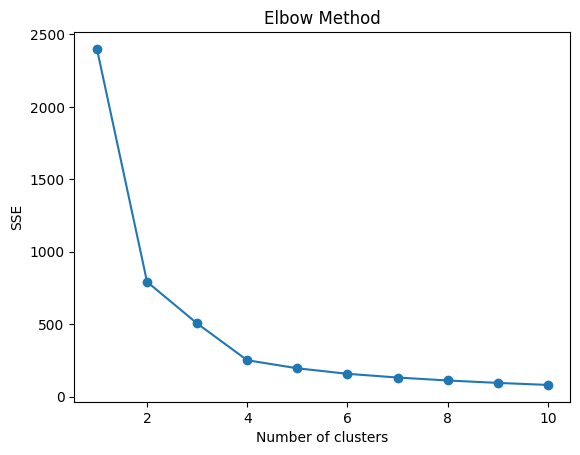

In [36]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# 엘보우 방법
sse = []
for k in range(1, 11):  # 예를 들어 1부터 10까지의 클러스터 수를 시도
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_standard)
    sse.append(kmeans.inertia_)

plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow Method')
plt.show()

# # 실루엣 점수
# sil_scores = []
# cluster_range = range(2, 11)  # 실루엣 점수는 최소 2개의 클러스터부터 계산 가능
# for k in cluster_range:
#     kmeans = KMeans(n_clusters=k)
#     cluster_labels = kmeans.fit_predict(df_pca)
#     sil_score = silhouette_score(df_pca, cluster_labels)
#     sil_scores.append(sil_score)

# plt.plot(cluster_range, sil_scores, marker='o')
# plt.xlabel('Number of clusters')
# plt.ylabel('Silhouette Score')
# plt.title('Silhouette Score Method')
# plt.show()


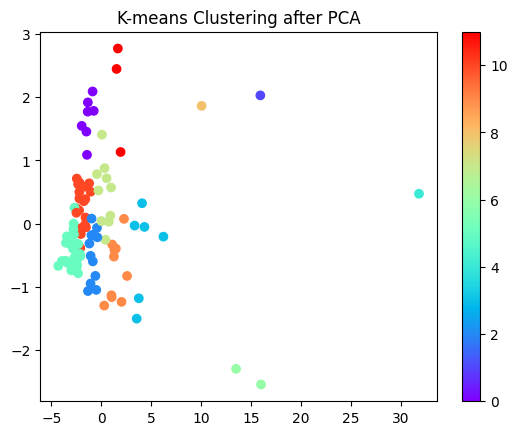

In [53]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# PCA로 차원 축소 (2차원으로)
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_standard)

# K-means 클러스터링
kmeans = KMeans(n_clusters=12) 
clusters = kmeans.fit_predict(df_pca)

# 결과 시각화
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=clusters, cmap='rainbow')
plt.title('K-means Clustering after PCA')
plt.colorbar()
plt.show()


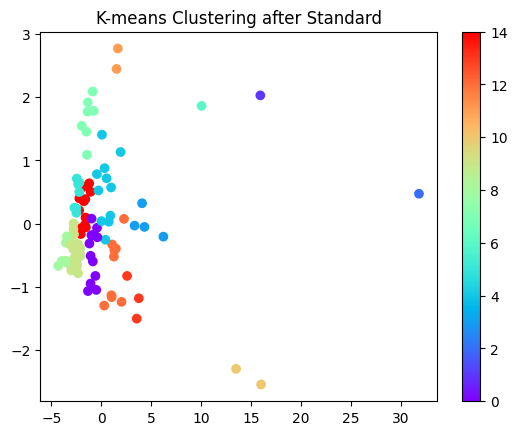

In [55]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
##
# K-means 클러스터링
kmeans = KMeans(n_clusters=15) 
clusters = kmeans.fit_predict(df_standard)

# 결과 시각화
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=clusters, cmap='rainbow')
plt.title('K-means Clustering after Standard')
plt.colorbar()
plt.show()


In [ ]:
# 최적의 클러스터 수를 사용하여 KMeans 클러스터링 수행
optimal_clusters =12# 실루엣 점수의 최대값에 해당하는 클러스터 수
kmeans = KMeans(n_clusters=optimal_clusters)
cluster_labels = kmeans.fit_predict(df_pca)

# 빌딩 번호를 포함하는 데이터프레임 생성
df_pca_df = pd.DataFrame(df_pca, columns=['PC1', 'PC2'])
df_pca_df['cluster_labels'] = cluster_labels
df_pca_df.index = range(1, len(df_pca_df) + 1)  # 빌딩 번호를 인덱스로 설정

# 각 클러스터에 속하는 빌딩의 번호 출력
for cluster_num in range(optimal_clusters):
    buildings_in_cluster = df_pca_df[df_pca_df['cluster_labels'] == cluster_num].index.tolist()
    print(f"Cluster {cluster_num}: Buildings {buildings_in_cluster}")


In [51]:
# 최적의 클러스터 수를 사용하여 KMeans 클러스터링 수행
optimal_clusters =12# 실루엣 점수의 최대값에 해당하는 클러스터 수
kmeans = KMeans(n_clusters=optimal_clusters)
cluster_labels = kmeans.fit_predict(df_pca)

# 빌딩 번호를 포함하는 데이터프레임 생성
df_pca_df = pd.DataFrame(df_pca, columns=['PC1', 'PC2'])
df_pca_df['cluster_labels'] = cluster_labels
df_pca_df.index = range(1, len(df_pca_df) + 1)  # 빌딩 번호를 인덱스로 설정

# 각 클러스터에 속하는 빌딩의 번호 출력
for cluster_num in range(optimal_clusters):
    buildings_in_cluster = df_pca_df[df_pca_df['cluster_labels'] == cluster_num].index.tolist()
    print(f"Cluster {cluster_num}: Buildings {buildings_in_cluster}")


Cluster 0: Buildings [13, 26, 34, 36, 45, 49, 50, 58, 61, 73]
Cluster 1: Buildings [27]
Cluster 2: Buildings [2, 3, 12, 18, 19, 20, 28, 29, 31, 59, 75, 77, 78, 81, 83, 84, 87, 88, 89, 90, 91, 92]
Cluster 3: Buildings [32, 33]
Cluster 4: Buildings [16, 37, 41]
Cluster 5: Buildings [25]
Cluster 6: Buildings [6, 38, 39, 40, 42, 43, 44, 54, 57, 80, 82]
Cluster 7: Buildings [10, 47, 56, 69, 70, 74]
Cluster 8: Buildings [4, 7, 8, 17, 22, 23, 30, 55, 62, 63, 64, 65, 66, 67, 72, 76, 86, 93, 95, 97, 98, 99, 100]
Cluster 9: Buildings [24]
Cluster 10: Buildings [11, 14, 15, 21, 35, 46, 48, 52, 53, 68, 71, 85]
Cluster 11: Buildings [1, 5, 9, 51, 60, 79, 94, 96]
